In [294]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import math
from sklearn.metrics import r2_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 1, 5 from 6.02.2024
# 12, 20 until 12.02.2024
# 4, 8 starting from 13.02.2024

start_date = datetime(2024, 2, 6, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 3, 1, 23, 59, 59).replace(tzinfo=timezone.utc)
system_ids = [1,3,4,5,6,8,9,10,11,12,13,20]

filter = '1h'

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")


In [295]:
def rmse(y_true, y_meas):
    MSE = np.square(np.subtract(y_true, y_meas)).mean()
    RMSE = math.sqrt(MSE)

    return RMSE

def calc_r2(y_true, y_meas):
    return r2_score(y_true, y_meas)

In [296]:
df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "slope_intercept_acropolis.parquet")) \
    .with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("timestamp")) #3.6e6 ms are in 1h

# Perform RANSAC only on slope and then select valid calibrations

In [297]:
def fit_ransac(x, y, date):
    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)
    T = np.array(date)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor(residual_threshold=0.01)
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    # plot
    lw = 2
    
    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"slope for system: {id}")
    plt.show()
    #----
    
    return inlier_mask

In [298]:
df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-12").filter(pl.col("creation_timestamp").is_between(start_date, end_date)).collect()

shape: (44, 6)
┌────────────┬───────────────────────┬──────────┬───────────┬──────────────────────┬───────────────┐
│ date       ┆ system_name           ┆ slope    ┆ intercept ┆ creation_timestamp   ┆ timestamp     │
│ ---        ┆ ---                   ┆ ---      ┆ ---       ┆ ---                  ┆ ---           │
│ date       ┆ str                   ┆ f64      ┆ f64       ┆ datetime[μs, UTC]    ┆ f64           │
╞════════════╪═══════════════════════╪══════════╪═══════════╪══════════════════════╪═══════════════╡
│ 2023-12-23 ┆ tum-esm-midcost-raspi ┆ 1.027195 ┆ 3.588909  ┆ 2023-12-23           ┆ 473138.527819 │
│            ┆ -12                   ┆          ┆           ┆ 02:31:40.150 UTC     ┆               │
│ 2023-12-24 ┆ tum-esm-midcost-raspi ┆ 1.025923 ┆ 4.069319  ┆ 2023-12-24           ┆ 473163.506203 │
│            ┆ -12                   ┆          ┆           ┆ 03:30:22.330 UTC     ┆               │
│ 2023-12-25 ┆ tum-esm-midcost-raspi ┆ 1.023164 ┆ 6.097302  ┆ 2023-12-25           ┆ 473188.365578 │
│            ┆ -12                   ┆          ┆           ┆ 04:21:56.080 UTC     ┆               │
│ 2023-12-26 ┆ tum-esm-midcost-raspi ┆ 1.025081 ┆ 5.027209  ┆ 2023-12-26           ┆ 473213.804506 │
│            ┆ -12                   ┆          ┆           ┆ 05:48:16.220 UTC     ┆               │
│ …          ┆ …                     ┆ …        ┆ …         ┆ …                    ┆ …             │
│ 2024-02-02 ┆ tum-esm-midcost-raspi ┆ 1.058436 ┆ -6.990568 ┆ 2024-02-02           ┆ 474123.532336 │
│            ┆ -12                   ┆          ┆           ┆ 03:31:56.410 UTC     ┆               │
│ 2024-02-03 ┆ tum-esm-midcost-raspi ┆ 1.056429 ┆ -8.591117 ┆ 2024-02-03           ┆ 474147.509889 │
│            ┆ -12                   ┆          ┆           ┆ 03:30:35.600 UTC     ┆               │
│ 2024-02-04 ┆ tum-esm-midcost-raspi ┆ 1.02493  ┆ 6.195187  ┆ 2024-02-04           ┆ 474171.346119 │
│            ┆ -12                   ┆          ┆           ┆ 03:20:46.030 UTC     ┆               │
│ 2024-02-05 ┆ tum-esm-midcost-raspi ┆ 1.043752 ┆ -3.211635 ┆ 2024-02-05           ┆ 474195.520897 │
│            ┆ -12                   ┆          ┆           ┆ 03:31:15.230 UTC     ┆               │
└────────────┴───────────────────────┴──────────┴───────────┴──────────────────────┴───────────────┘

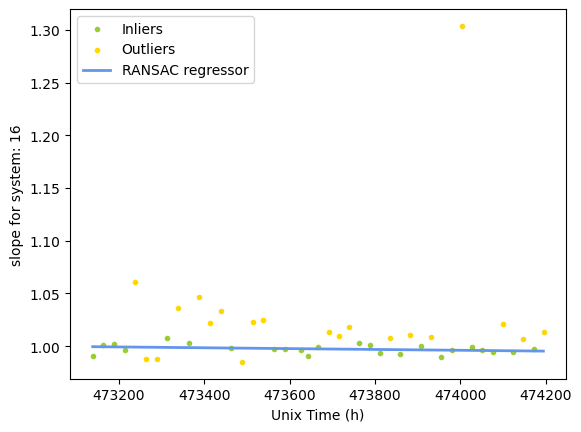

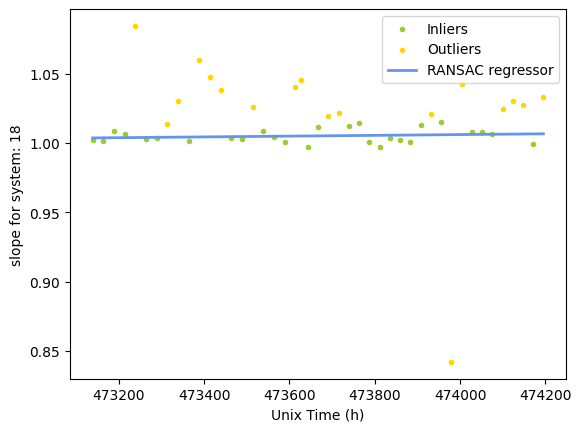

In [299]:
l_df_cor = []

for id in system_ids:
    try:
        df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

        y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
        x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()
        d = df_sys.select(pl.col("creation_timestamp")).collect().to_series().to_list()
        mask = fit_ransac(x,y,d)

        df_sys = df_sys.with_columns(mask = pl.Series(mask)).collect()
        
        l_df_cor.append(df_sys)
    except Exception as e:
        print(e)
        print(f"Could not find calibrations for system {id}")
    

df_cal_ransac = pl.concat(l_df_cor, how="diagonal")

In [300]:
df_cal_ransac = df_cal_ransac.with_columns((pl.col("slope") * pl.col("mask")).alias("ransac_slope")) \
    .with_columns((pl.col("intercept") * pl.col("mask")).alias("ransac_intercept")) \
    .filter(pl.col("mask") == True) \
    .sort("creation_timestamp") \
    .lazy()
    
df_cal_ransac.head(3).collect()

shape: (3, 9)
┌────────────┬────────────┬──────────┬────────────┬───┬────────────┬──────┬────────────┬───────────┐
│ date       ┆ system_nam ┆ slope    ┆ intercept  ┆ … ┆ timestamp  ┆ mask ┆ ransac_slo ┆ ransac_in │
│ ---        ┆ e          ┆ ---      ┆ ---        ┆   ┆ ---        ┆ ---  ┆ pe         ┆ tercept   │
│ date       ┆ ---        ┆ f64      ┆ f64        ┆   ┆ f64        ┆ bool ┆ ---        ┆ ---       │
│            ┆ str        ┆          ┆            ┆   ┆            ┆      ┆ f64        ┆ f64       │
╞════════════╪════════════╪══════════╪════════════╪═══╪════════════╪══════╪════════════╪═══════════╡
│ 2023-12-23 ┆ tum-esm-mi ┆ 1.00255  ┆ -1.302809  ┆ … ┆ 473138.353 ┆ true ┆ 1.00255    ┆ -1.302809 │
│            ┆ dcost-rasp ┆          ┆            ┆   ┆ 919        ┆      ┆            ┆           │
│            ┆ i-18       ┆          ┆            ┆   ┆            ┆      ┆            ┆           │
│ 2023-12-23 ┆ tum-esm-mi ┆ 0.990192 ┆ -21.427113 ┆ … ┆ 473138.539 ┆ true ┆ 0.990192   ┆ -21.42711 │
│            ┆ dcost-rasp ┆          ┆            ┆   ┆ 072        ┆      ┆            ┆ 3         │
│            ┆ i-16       ┆          ┆            ┆   ┆            ┆      ┆            ┆           │
│ 2023-12-24 ┆ tum-esm-mi ┆ 1.001302 ┆ -1.046871  ┆ … ┆ 473163.339 ┆ true ┆ 1.001302   ┆ -1.046871 │
│            ┆ dcost-rasp ┆          ┆            ┆   ┆ 092        ┆      ┆            ┆           │
│            ┆ i-18       ┆          ┆            ┆   ┆            ┆      ┆            ┆           │
└────────────┴────────────┴──────────┴────────────┴───┴────────────┴──────┴────────────┴───────────┘

In [301]:
df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [302]:
df_dry.head(1).collect()

shape: (1, 7)
┌───────────────┬───────────────┬────────────┬──────────┬──────────┬───────────────┬───────────────┐
│ creation_time ┆ system_name   ┆ gmp343_dry ┆ h2o_ah   ┆ h2o_ppm  ┆ gmp343_temper ┆ bme280_pressu │
│ stamp         ┆ ---           ┆ ---        ┆ ---      ┆ ---      ┆ ature         ┆ re            │
│ ---           ┆ str           ┆ f64        ┆ f64      ┆ f64      ┆ ---           ┆ ---           │
│ datetime[μs,  ┆               ┆            ┆          ┆          ┆ f64           ┆ f64           │
│ UTC]          ┆               ┆            ┆          ┆          ┆               ┆               │
╞═══════════════╪═══════════════╪════════════╪══════════╪══════════╪═══════════════╪═══════════════╡
│ 2023-12-23    ┆ tum-esm-midco ┆ 465.461061 ┆ 8.225519 ┆ 1.240217 ┆ 30.008333     ┆ 927.936667    │
│ 00:00:00 UTC  ┆ st-raspi-1    ┆            ┆          ┆          ┆               ┆               │
└───────────────┴───────────────┴────────────┴──────────┴──────────┴───────────────┴───────────────┘

In [303]:
l_df_dry_cut = []

for id in system_ids:
    
    df_temp = df_dry.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}")
    
    #cut maintainence / power outtage from 23.01.2024
    if id in [10,11,13]:
        before = df_temp.filter(pl.col("creation_timestamp") < datetime(2024, 1, 23, 14, 0, 0).replace(tzinfo=timezone.utc))
        after = df_temp.filter(pl.col("creation_timestamp") > datetime(2024, 1, 24, 3, 30, 0).replace(tzinfo=timezone.utc))

        df_temp = pl.concat([before, after], how="diagonal")
        
    # 12, 20 moved to deployment roof top    
    if id in [5,1]:
        df_temp = df_temp.filter(pl.col("creation_timestamp") > datetime(2024, 2, 7, 0, 0, 0).replace(tzinfo=timezone.utc))
     
    # 12, 20 moved to deployment roof top    
    if id in [9,12,20]:
        df_temp = df_temp.filter(pl.col("creation_timestamp") < datetime(2024, 2, 12, 9, 0, 0).replace(tzinfo=timezone.utc))
        
    # 4,8 brought in from deployment; 9 finished drying  
    if id in [4,8,9]:
        df_temp = df_temp.filter(pl.col("creation_timestamp") > datetime(2024, 2, 13, 0, 0, 0).replace(tzinfo=timezone.utc))
        
    l_df_dry_cut.append(df_temp)
    
df_dry = pl.concat(l_df_dry_cut, how="diagonal")

In [304]:
df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
        .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")

        
l_df_cal_corr =[df_p_1h]

for id in system_ids:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "backward") \
    .fill_null(strategy = "forward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='1h')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_1h.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg_1h = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg_1h.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_cal_corr_acropolis.parquet"))


In [305]:
df_cal_corr_agg_1h.head(1)

shape: (1, 18)
┌────────────┬────────────┬────────────┬──────────┬───┬───────────┬──────┬────────────┬────────────┐
│ creation_t ┆ CO2_corr   ┆ h2o_report ┆ slope    ┆ … ┆ timestamp ┆ mask ┆ ransac_slo ┆ ransac_int │
│ imestamp   ┆ ---        ┆ ed         ┆ ---      ┆   ┆ ---       ┆ ---  ┆ pe         ┆ ercept     │
│ ---        ┆ f64        ┆ ---        ┆ f64      ┆   ┆ f64       ┆ f64  ┆ ---        ┆ ---        │
│ datetime[μ ┆            ┆ f64        ┆          ┆   ┆           ┆      ┆ f64        ┆ f64        │
│ s, UTC]    ┆            ┆            ┆          ┆   ┆           ┆      ┆            ┆            │
╞════════════╪════════════╪════════════╪══════════╪═══╪═══════════╪══════╪════════════╪════════════╡
│ 2023-12-23 ┆ 428.148412 ┆ 1.186139   ┆ 1.006043 ┆ … ┆ null      ┆ null ┆ null       ┆ null       │
│ 00:00:00   ┆            ┆            ┆          ┆   ┆           ┆      ┆            ┆            │
│ UTC        ┆            ┆            ┆          ┆   ┆           ┆      ┆            ┆            │
└────────────┴────────────┴────────────┴──────────┴───┴───────────┴──────┴────────────┴────────────┘

In [306]:
df_p_10m = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "10m_cal_corr_picarro.parquet")) \
        .filter(pl.col("creation_timestamp").is_between(start_date, end_date)) \
        .rename({"h2o_reported": "h2o_ppm"})

# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")

        
l_df_cal_corr =[df_p_10m]

for id in system_ids:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "forward") \
    .fill_null(strategy = "backward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='10m')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_10m.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg_10m = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg_10m.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "10m_cal_corr_acropolis.parquet"))


In [307]:
import plotly.express as px

#dataframe = df_cal_corr_agg_1h
dataframe = df_cal_corr_agg_10m

fig = px.line(dataframe, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2 Dry", color="system_name")
fig.show()

fig = px.line(dataframe, x="creation_timestamp", y=f"diff", markers=True, title = "Difference Acropolis System - PICARRO", color="system_name")
fig.show()

fig = px.line(dataframe, x="creation_timestamp", y=f"h2o_ppm", markers=True, title = "Absolute Humidity (Picarro in ppm)", color="system_name")
fig.show()

In [308]:
titles = []
for system_id in system_ids:
    titles.append(f"System: {system_id}")

fig = make_subplots(rows=4, cols=3, shared_yaxes='all', subplot_titles=(titles), x_title="ACROPOLIS (ppm)", y_title="Picarro (ppm)")
fig2 = make_subplots(rows=4, cols=3, shared_yaxes='all',  subplot_titles=(titles), x_title="ACROPOLIS (ppm)", y_title="Picarro (ppm)")
row = 1
col = 0

for system_id in system_ids:
    
    col += 1
    
    if col == 4:
        col = 1
        row += 1

    print(f"\nAnalysis for System {system_id}:")

    #----
    df_acropolis = dataframe.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr", "h2o_ppm"]) \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"}) \
        .rename({"h2o_ppm": f"H2O_acropolis_{system_id}"})
        
    df_picarro = dataframe.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr","h2o_ppm"]) \
        .rename({"CO2_corr": f"CO2_picarro"}) \
        .rename({"h2o_ppm": f"H2O_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_picarro_h2o = df_analysis.select("H2O_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    l_acropolis_h2o = df_analysis.select(f"H2O_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        #plotly scatterplot
        fig.add_trace(go.Scatter(x=l_acropolis, y=l_picarro, name = f"MC-{system_id}", mode='markers'),row=row, col=col) 
        fig2.add_trace(go.Scatter(x=l_acropolis_h2o, y=l_picarro_h2o,  name = f"MC-{system_id}", mode='markers'),row=row, col=col)
        
        mean_offset = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
        #print(f"Offset {mean_offset}")
        
        rmse_result = rmse(l_picarro,l_acropolis)
        #print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        #print(f"R2: {r2_result}")
        
        print(f"Offset {mean_offset}, RMSE: {rmse_result}, R2: {r2_result}")
   
fig.update_layout(title_text="Scatter Plots: CO2 (dry)", height=1000, width=1000, showlegend=False)
#fig.update_layout(xaxis=dict(tickmode='linear',tick0=10,dtick=10), yaxis=dict(tickmode='linear',tick0=10,dtick=10))     
fig.show()
fig2.update_layout(title_text="Scatter Plots: Water Vaport (ppm)", height=1000, width=1000, showlegend=False)
#fig2.update_layout(xaxis=dict(tickmode='linear',tick0=0.25,dtick=0.25), yaxis=dict(tickmode='linear',tick0=0.25,dtick=0.25))    
fig2.show()


Analysis for System 16:
Offset 0.022447674056060074, RMSE: 1.0637109621182246, R2: 0.9967512583385225

Analysis for System 18:
Offset 0.007187962517527784, RMSE: 0.9965251222251257, R2: 0.9973275484042744


# Delta CO2 vs. Temperature, Pressure, Humidity

In [309]:
dataframe.head(3)

shape: (3, 17)
┌─────────────┬────────────┬──────────┬──────────┬───┬───────────┬──────┬─────────────┬────────────┐
│ creation_ti ┆ CO2_corr   ┆ h2o_ppm  ┆ slope    ┆ … ┆ timestamp ┆ mask ┆ ransac_slop ┆ ransac_int │
│ mestamp     ┆ ---        ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---  ┆ e           ┆ ercept     │
│ ---         ┆ f64        ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64  ┆ ---         ┆ ---        │
│ datetime[μs ┆            ┆          ┆          ┆   ┆           ┆      ┆ f64         ┆ f64        │
│ , UTC]      ┆            ┆          ┆          ┆   ┆           ┆      ┆             ┆            │
╞═════════════╪════════════╪══════════╪══════════╪═══╪═══════════╪══════╪═════════════╪════════════╡
│ 2023-12-23  ┆ 428.340419 ┆ 1.188302 ┆ 1.006043 ┆ … ┆ null      ┆ null ┆ null        ┆ null       │
│ 00:00:00    ┆            ┆          ┆          ┆   ┆           ┆      ┆             ┆            │
│ UTC         ┆            ┆          ┆          ┆   ┆           ┆      ┆             ┆            │
│ 2023-12-23  ┆ 428.239287 ┆ 1.192396 ┆ 1.006043 ┆ … ┆ null      ┆ null ┆ null        ┆ null       │
│ 00:10:00    ┆            ┆          ┆          ┆   ┆           ┆      ┆             ┆            │
│ UTC         ┆            ┆          ┆          ┆   ┆           ┆      ┆             ┆            │
│ 2023-12-23  ┆ 428.092774 ┆ 1.191355 ┆ 1.006043 ┆ … ┆ null      ┆ null ┆ null        ┆ null       │
│ 00:20:00    ┆            ┆          ┆          ┆   ┆           ┆      ┆             ┆            │
│ UTC         ┆            ┆          ┆          ┆   ┆           ┆      ┆             ┆            │
└─────────────┴────────────┴──────────┴──────────┴───┴───────────┴──────┴─────────────┴────────────┘

In [310]:
titles = []
for system_id in system_ids:
    titles.append(f"System: {system_id}")

fig = make_subplots(rows=4, cols=3, shared_yaxes='all', subplot_titles=(titles), x_title="Humidity (ppm)", y_title="ACROPOLIS - Picarro (ppm)")

row = 1
col = 0

for system_id in system_ids:
    
    col += 1
    
    if col == 4:
        col = 1
        row += 1

    #----
    df_plot = dataframe.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "diff", "h2o_ppm"]) \
        
    l_delta = df_plot.select("diff").to_series().to_list()
    l_humidity = df_plot.select("h2o_ppm").to_series().to_list()
    
    fig.add_trace(go.Scatter(x=l_humidity, y=l_delta, name = f"MC-{system_id}", mode='markers'),row=row, col=col)

    
fig.update_layout(title_text="Scatter Plots: Delta CO2 vs Humidity", height=1000, width=1000, showlegend=False)
#fig.update_layout(xaxis=dict(tickmode='linear',tick0=10,dtick=10), yaxis=dict(tickmode='linear',tick0=10,dtick=10))     
fig.show()


In [311]:
titles = []
for system_id in system_ids:
    titles.append(f"System: {system_id}")

fig = make_subplots(rows=4, cols=3, shared_yaxes='all', subplot_titles=(titles), x_title="GMP343 Temperature (°C)", y_title="ACROPOLIS - Picarro (ppm)")

row = 1
col = 0

for system_id in system_ids:
    
    col += 1
    
    if col == 4:
        col = 1
        row += 1

    #----
    df_plot = dataframe.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "diff", "gmp343_temperature"]) \
        
    l_delta = df_plot.select("diff").to_series().to_list()
    l_humidity = df_plot.select("gmp343_temperature").to_series().to_list()
    
    fig.add_trace(go.Scatter(x=l_humidity, y=l_delta, name = f"MC-{system_id}", mode='markers'),row=row, col=col)

    
fig.update_layout(title_text="Scatter Plots: Delta CO2 vs Temperature", height=1000, width=1000, showlegend=False,
                  xaxis1 = dict(range=[23, 32]),
                  xaxis2 = dict(range=[23, 32]),
                  xaxis3 = dict(range=[23, 32]),
                  xaxis4 = dict(range=[23, 32]),
                  xaxis5 = dict(range=[23, 32]),
                  xaxis6 = dict(range=[23, 32]),
                  xaxis7 = dict(range=[23, 32]),
                  xaxis8 = dict(range=[23, 32]),
                  xaxis9 = dict(range=[23, 32]),)
#fig.update_layout(xaxis=dict(tickmode='linear',tick0=10,dtick=10), yaxis=dict(tickmode='linear',tick0=10,dtick=10))     
fig.show()


In [312]:
titles = []
for system_id in system_ids:
    titles.append(f"System: {system_id}")

fig = make_subplots(rows=4, cols=3, shared_yaxes='all', subplot_titles=(titles), x_title="BME280 Inlet Pressure (hPa)", y_title="ACROPOLIS - Picarro (ppm)")

row = 1
col = 0

for system_id in system_ids:
    
    col += 1
    
    if col == 4:
        col = 1
        row += 1

    #----
    df_plot = dataframe.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "diff", "bme280_pressure"]) \
        
    l_delta = df_plot.select("diff").to_series().to_list()
    l_humidity = df_plot.select("bme280_pressure").to_series().to_list()
    
    fig.add_trace(go.Scatter(x=l_humidity, y=l_delta, name = f"MC-{system_id}", mode='markers'),row=row, col=col)

    
fig.update_layout(title_text="Scatter Plots: Delta CO2 vs Inlet Pressure", height=1000, width=1000, showlegend=False)
#fig.update_layout(xaxis=dict(tickmode='linear',tick0=10,dtick=10), yaxis=dict(tickmode='linear',tick0=10,dtick=10))     
fig.show()


# Substract mean offset

In [313]:
for system_id in system_ids:

    print(f"\nAnalysis for System {system_id}:")

    #----
    mean_offset = 0
    if len(l_acropolis) > 0:
        mean_offset = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
    
    df_acropolis = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .with_columns(pl.col("CO2_corr") - mean_offset)  \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"})
        
    df_picarro = df_cal_corr_agg_1h.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        rmse_result = rmse(l_picarro,l_acropolis)
        #print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        #print(f"R2: {r2_result}")
        
        print(f"RMSE: {rmse_result}, R2: {r2_result}")


Analysis for System 16:
RMSE: 0.9223881755613857, R2: 0.9974821208193176

Analysis for System 18:
RMSE: 0.8481907728417021, R2: 0.9980186249828544
